In [1]:
import os
from typing import Union, Optional, List, Tuple

import torch
from torch import nn
import numpy as np
from matplotlib import pyplot as plt

from data_loader import H5Dataset

In [2]:
from pynvml import *
nvmlInit()

In [3]:
def conv_block(channels: Tuple[int, int],size: Tuple[int, int],
               stride: Tuple[int, int]=(1, 1),
               N: int=1):
    block = lambda in_channels: nn.Sequential(
        nn.Conv2d(in_channels=in_channels,
                  out_channels=channels[1],
                  kernel_size=size,
                  stride=stride,
                  bias=False,
                  padding=(size[0] // 2, size[1] // 2)),
        nn.BatchNorm2d(num_features=channels[1]),
        nn.ReLU()
    )
    return nn.Sequential(*[block(channels[bool(i)]) for i in range(N)])

In [4]:
class ConvCat(nn.Module):
    def __init__(self,
                 channels: Tuple[int, int],
                 size: Tuple[int, int],
                 stride: Tuple[int, int]=(1, 1),
                 N: int=1):
        super(ConvCat, self).__init__()
        self.conv = nn.Sequential(
            conv_block(channels, size, stride, N),
            nn.Upsample(scale_factor=2)
        )

    def forward(self, to_conv: torch.Tensor, to_cat: torch.Tensor):
        return torch.cat([self.conv(to_conv), to_cat], dim=1)

In [71]:
class UNet(nn.Module):
    def __init__(self, filters: int=64, input_filters: int=3, **kwargs):
        super(UNet, self).__init__()
        # first block channels size
        initial_filters = (input_filters, filters)
        # channels size for downsampling
        down_filters = (filters, filters)
        # channels size for upsampling (input doubled because of concatenate)
        up_filters = (2 * filters, filters)

        # downsampling
        self.block1 = conv_block(channels=initial_filters, size=(3, 3), N=2)
        self.block2 = conv_block(channels=down_filters, size=(3, 3), N=2)
        self.block3 = conv_block(channels=down_filters, size=(3, 3), N=2)

        # upsampling
        self.block4 = ConvCat(channels=down_filters, size=(3, 3), N=2)
        self.block5 = ConvCat(channels=up_filters, size=(3, 3), N=2)
        self.block6 = ConvCat(channels=up_filters, size=(3, 3), N=2)

        # density prediction
        self.block7 = conv_block(channels=up_filters, size=(3, 3), N=2)
        self.density_pred = nn.Conv2d(in_channels=filters, out_channels=1,
                                      kernel_size=(1, 1), bias=False)

    def forward(self, input: torch.Tensor):
        """Forward pass."""
        # use the same max pooling kernel size (2, 2) across the network
        pool = nn.MaxPool2d(2)

        # downsampling
        block1 = self.block1(input)
        pool1 = pool(block1)
        block2 = self.block2(pool1)
        pool2 = pool(block2)
        block3 = self.block3(pool2)
        pool3 = pool(block3)

        # upsampling
        block4 = self.block4(pool3, block3)
        block5 = self.block5(block4, block2)
        block6 = self.block6(block5, block1)

        # density prediction
        block7 = self.block7(block6)
        return self.density_pred(block7)

In [65]:
def best_cuda():
    l=[]
    for i in range(8):
        h = nvmlDeviceGetHandleByIndex(i)
        info = nvmlDeviceGetMemoryInfo(h)
        l.append([info.free,info.used,info.total,i])
    l=sorted(l,reverse=True)
#     print(l)
    l=np.array(l)
    return l[:,-1].tolist()

In [107]:
dataset_name='ucsd'
learning_rate=1e-2
epochs=30
batch_size=32
horizontal_flip=0.0
vertical_flip=0.0
unet_filters=64
convolutions=2
validation=False

<!-- train(dataset_name,learning_rate,
      epochs,batch_size,
      horizontal_flip,vertical_flip,
      unet_filter,convolutions,True) -->

In [108]:
def train_model(network,train_loader,val_loader,
                epochs: int,
                loss_f,
                optimizer):
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=12,gamma=0.1)
    
    history1 = []
    history2 = []
    
    # current best results (lowest mean absolute error on validation set)
    current_best = np.infty

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}\n")
        # run training epoch and update learning rate
        
        # reset current results and add next entry for running loss
        train_true_values = []
        train_predicted_values = []
        train_running_loss=[]
        train_running_loss.append(0)
        
        val_true_values = []
        val_predicted_values = []
        val_running_loss=[]
        val_running_loss.append(0)

        # set a proper mode: train or eval
        network.train()

        for image, label in train_dataloader:
            # move images and labels to given device
            image = image.to(device)
            label = label.to(device)
            optimizer.zero_grad()
            
            # get model prediction (a density map)
            result = network(image)
            loss = loss_f(result, label)
            train_running_loss[-1] += image.shape[0] * loss.item() / len(train_dataset)
            loss.backward()
            optimizer.step()

            # loop over batch samples
            for true, predicted in zip(label, result):
                # integrate a density map to get no. of objects
                # note: density maps were normalized to 100 * no. of objects
                #       to make network learn better
                train_true_counts = torch.sum(true).item() / 100
                train_predicted_counts = torch.sum(predicted).item() / 100

                # update current epoch results
                train_true_values.append(train_true_counts)
                train_predicted_values.append(train_predicted_counts)
                
        # calculate errors and standard deviation
        train_err = [true - predicted for true, predicted in zip(train_true_values, train_predicted_values)]
        train_abs_err = [abs(error) for error in train_err]
        train_mean_err = sum(train_err) / len(train_dataset)
        train_mean_abs_err = sum(train_abs_err) / len(train_dataset)


        # print epoch summary
        print(f"Train:\n"
              f"\tAverage loss: {train_running_loss[-1]:3.4f}\n"
              f"\tMean error: {train_mean_err:3.3f}\n"
              f"\tMean absolute error: {train_mean_abs_err:3.3f}\n"
             )
        lr_scheduler.step()
        
        #validation
        for image, label in val_dataloader:
            # move images and labels to given device
            image = image.to(device)
            label = label.to(device)
            with torch.no_grad():
                result = network(image)
                loss = loss_f(result, label)
                val_running_loss[-1] += image.shape[0] * loss.item() / len(val_dataset)
            # loop over batch samples
            for true, predicted in zip(label, result):
                val_true_counts = torch.sum(true).item() / 100
                val_predicted_counts = torch.sum(predicted).item() / 100
                
                val_true_values.append(val_true_counts)
                val_predicted_values.append(val_predicted_counts)

        # calculate errors and standard deviation
        val_err = [true - predicted for true, predicted in zip(val_true_values, val_predicted_values)]
        val_abs_err = [abs(error) for error in val_err]
        val_mean_err = sum(val_err) / len(val_dataset)
        val_mean_abs_err = sum(val_abs_err) / len(val_dataset)

        # print epoch summary
        print(f"Valid:\n"
              f"\tAverage loss: {val_running_loss[-1]:3.4f}\n"
              f"\tMean error: {val_mean_err:3.3f}\n"
              f"\tMean absolute error: {val_mean_abs_err:3.3f}\n"

             )
        
        history1.append({'tloss':train_running_loss[-1],'vloss':val_running_loss[-1]})
        history2.append({'tmerr':train_mean_abs_err,'vmerr':val_mean_abs_err})
        
#         update checkpoint if new best is reached
        if val_running_loss[-1] < current_best:
            current_best = val_running_loss[-1]
            torch.save(network.state_dict(),'model_UNet.pth')

            print(f"\nNew best result: {current_best:3.4f}")

    print(f"[Training done]")
    return network,history1,history2


In [109]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device: {device}')
print(f'current device: {torch.cuda.current_device()}')
if (torch.cuda.is_available()):
    torch.cuda.set_device(best_cuda()[0])
print(f'current device: {torch.cuda.current_device()}')


# expected HDF5 files in dataset_name/(train | valid).h5
data_path = os.path.join(dataset_name, f"train.h5")

# turn on flips only for training dataset
train_dataset = H5Dataset(data_path,horizontal_flip,vertical_flip)
train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size)

data_path = os.path.join(dataset_name, f"valid.h5")
val_dataset = H5Dataset(data_path,0,0)
val_dataloader = torch.utils.data.DataLoader(val_dataset,batch_size=batch_size)

# only UCSD dataset provides greyscale images 
input_channels = 1 if dataset_name == 'ucsd' else 3

# initialize a model based on chosen network_architecture
network = UNet(input_filters=input_channels,
               filters=unet_filters,
               N=convolutions).to(device)

# initialize loss, optimized and learning rate scheduler
loss_f = torch.nn.MSELoss()
opt_fn = torch.optim.SGD(network.parameters(),lr=learning_rate,momentum=0.9,weight_decay=1e-5)
# opt_fn = torch.optim.Adam(network.parameters(),lr=learning_rate,weight_decay=1e-5)

device: cuda
current device: 3
current device: 1


In [110]:
network,hist1,hist2=train_model(network,train_dataloader,val_dataloader,epochs,loss_f,opt_fn)

Epoch 1

Train:
	Average loss: 0.5050
	Mean error: 0.850
	Mean absolute error: 12.192

Valid:
	Average loss: 0.4832
	Mean error: 2.528
	Mean absolute error: 7.258


New best result: 0.4832
Epoch 2

Train:
	Average loss: 0.4367
	Mean error: 0.140
	Mean absolute error: 7.696

Valid:
	Average loss: 0.4501
	Mean error: -3.762
	Mean absolute error: 9.371


New best result: 0.4501
Epoch 3

Train:
	Average loss: 0.4150
	Mean error: -0.337
	Mean absolute error: 12.524

Valid:
	Average loss: 0.4365
	Mean error: -3.187
	Mean absolute error: 9.044


New best result: 0.4365
Epoch 4

Train:
	Average loss: 0.4004
	Mean error: -0.102
	Mean absolute error: 12.527

Valid:
	Average loss: 0.4228
	Mean error: -5.708
	Mean absolute error: 10.361


New best result: 0.4228
Epoch 5

Train:
	Average loss: 0.3895
	Mean error: -1.782
	Mean absolute error: 10.606

Valid:
	Average loss: 0.4243
	Mean error: 0.681
	Mean absolute error: 8.483

Epoch 6

Train:
	Average loss: 0.3808
	Mean error: -1.044
	Mean absolute e

In [111]:
tloss = [i['tloss'] for i in hist1]
vloss = [i['vloss'] for i in hist1]

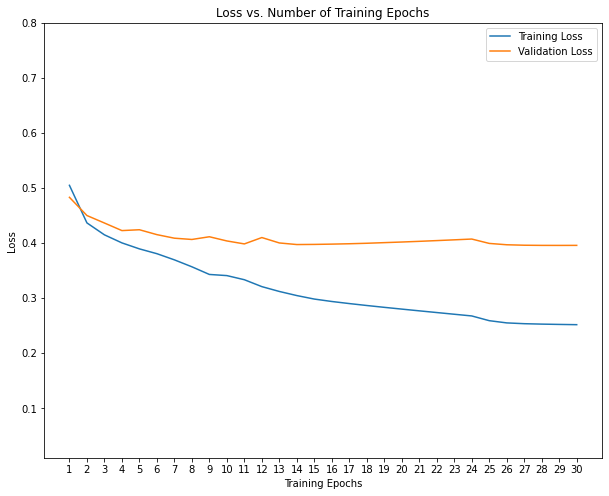

In [112]:
plt.figure(figsize=(10,8))
plt.title('Loss vs. Number of Training Epochs')
plt.xlabel('Training Epochs')
plt.ylabel('Loss')
plt.plot(range(1,len(tloss)+1),tloss,label="Training Loss")
plt.plot(range(1,len(vloss)+1),vloss,label="Validation Loss")
plt.ylim((0.01,0.8))
plt.xticks(np.arange(1, epochs+1, 1.0))
plt.legend()
plt.show()

In [113]:
tmerr = [i['tmerr'] for i in hist2]
vmerr = [i['vmerr'] for i in hist2]

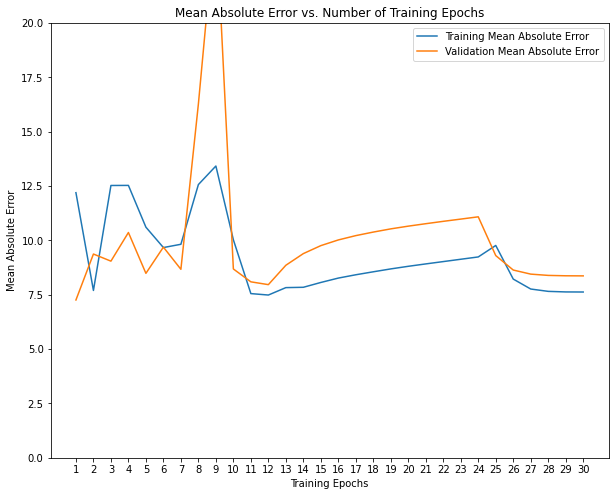

In [114]:
plt.figure(figsize=(10,8))
plt.title('Mean Absolute Error vs. Number of Training Epochs')
plt.xlabel('Training Epochs')
plt.ylabel('Mean Absolute Error')
plt.plot(range(1,len(tmerr)+1),tmerr,label="Training Mean Absolute Error")
plt.plot(range(1,len(vmerr)+1),vmerr,label="Validation Mean Absolute Error")
plt.ylim((0,20))
plt.xticks(np.arange(1, epochs+1, 1.0))
plt.legend()
plt.show()

In [115]:

files = os.listdir('testfiles')
from torchvision.datasets import ImageFolder
from torchvision import transforms
test_dataset = ImageFolder('testfiles/', transform= transforms.Compose([transforms.Grayscale(1),transforms.ToTensor()]))
test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size=1)

In [116]:
network.load_state_dict(torch.load('model_UNet.pth'))

<All keys matched successfully>

In [117]:
for params in network.state_dict():
    print(params)

block1.0.0.weight
block1.0.1.weight
block1.0.1.bias
block1.0.1.running_mean
block1.0.1.running_var
block1.0.1.num_batches_tracked
block1.1.0.weight
block1.1.1.weight
block1.1.1.bias
block1.1.1.running_mean
block1.1.1.running_var
block1.1.1.num_batches_tracked
block2.0.0.weight
block2.0.1.weight
block2.0.1.bias
block2.0.1.running_mean
block2.0.1.running_var
block2.0.1.num_batches_tracked
block2.1.0.weight
block2.1.1.weight
block2.1.1.bias
block2.1.1.running_mean
block2.1.1.running_var
block2.1.1.num_batches_tracked
block3.0.0.weight
block3.0.1.weight
block3.0.1.bias
block3.0.1.running_mean
block3.0.1.running_var
block3.0.1.num_batches_tracked
block3.1.0.weight
block3.1.1.weight
block3.1.1.bias
block3.1.1.running_mean
block3.1.1.running_var
block3.1.1.num_batches_tracked
block4.conv.0.0.0.weight
block4.conv.0.0.1.weight
block4.conv.0.0.1.bias
block4.conv.0.0.1.running_mean
block4.conv.0.0.1.running_var
block4.conv.0.0.1.num_batches_tracked
block4.conv.0.1.0.weight
block4.conv.0.1.1.weigh

In [118]:
for parameter in network.parameters():
    parameter.requires_grad = False
network.eval()

UNet(
  (block1): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (block2): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (block3): Sequential(
    (0): Sequen

In [121]:

def evaluate(model,test_dataloader,criterion):
    
    
#     model.eval()
    for image, _ in test_dataloader:# move images and labels to given device
        plt.imshow(image.squeeze(),cmap='gray')
        plt.show()
        image = image.to(device)
#         label = label.to(device)
        with torch.no_grad():
            result = network(image)
        train_predicted_counts = torch.sum(result).item() / 100 
        print('Counted people:{}'.format(int(train_predicted_counts)))


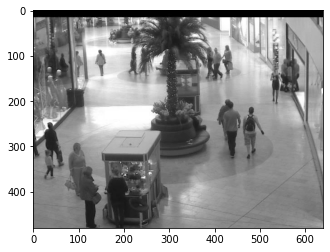

Counted people:45


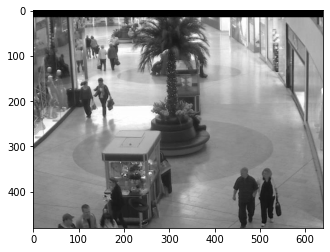

Counted people:48


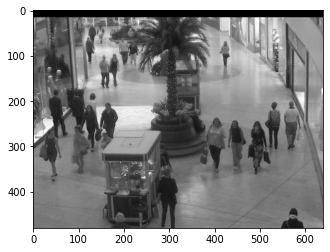

Counted people:73


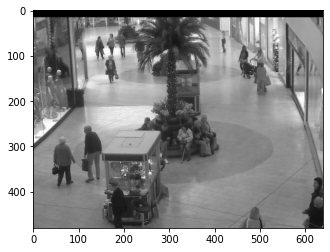

Counted people:46


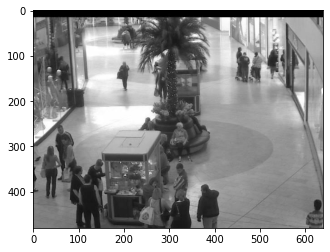

Counted people:58


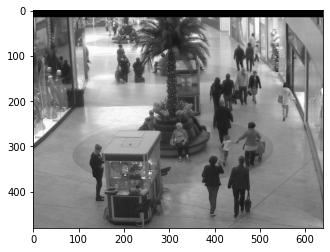

Counted people:61


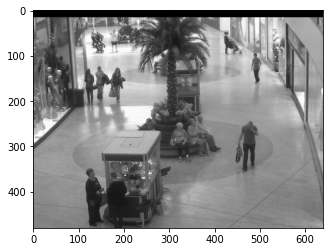

Counted people:51


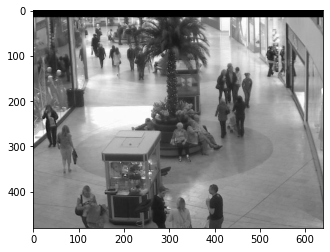

Counted people:64


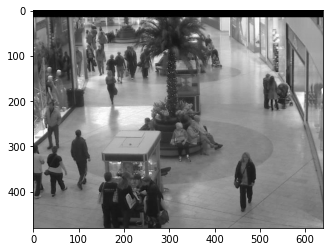

Counted people:63


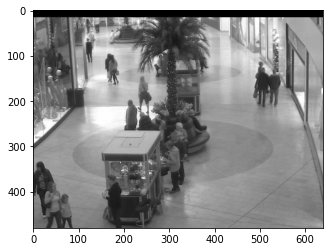

Counted people:40


In [122]:
evaluate(network,test_dataloader,loss_f)